# Import & UDFs
## Importing libraries

In [75]:
import pandas as pd 
pd.set_option("display.max_columns", None)
import numpy as np

import time
import os

import caffeine    

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns 
sns.set_theme(style="darkgrid", palette="Set1")

import klib

import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.colors import n_colors

import warnings
warnings.filterwarnings('ignore')

import folium

import re

import chart_studio
import chart_studio.plotly as py

username = "marclelamy" 
api_key = "bKX3HXMQHk2Yb2yxzvvh" 

chart_studio.tools.set_credentials_file(username=username, api_key=api_key)




## UDFs
### Missing DF

In [76]:
def missing(df):
    """Displays a table with missing value count and percentage. 
    Variables with no missing value are not shown."""
    
    df_missing = df.isna().sum().to_frame()
    df_missing.columns = ["missing_val_count"]
        
    df_missing["missing_val_percent"] = round(df_missing.missing_val_count / len(df) * 100, 1)
    df_missing = df_missing[df_missing["missing_val_count"] != 0]
    
    try:
        display(df_missing)
    except NameError:
        return df_missing

### Say something

I generally use it to know when a program that take multiple minutes to run is done or when I run the entire notebook

In [77]:
def say(string):
    os.system(f"say “{string}”")
    
def namestr(obj):
    return [name for name in globals() if globals()[name] is obj]

def table (df, row_size=40):
    for col in df.columns:
        df[col] = df[col].apply(lambda x: x.replace(" ", "<br>") if type(x) == str else x)
    
    table_data = [df.columns] + df.values.tolist()[:10]

    
    return ff.create_table(table_data)



## Import & merge CSVs 

Here I'm importing all the CSVs containing the scraped data. To scrape the data more rapidly, I did run four instanced of the script, that's why, four CSVs.

In [78]:
df_games = pd.read_csv(f"data/pl_data_games.csv")
df_events = pd.read_csv(f"data/pl_data_events.csv")
df_players = pd.read_csv(f"data/pl_data_players.csv")
df_stats = pd.read_csv("data/pl_data_stats.csv")

for df in [df_games, df_events, df_players, df_stats]:
    print(f"We have {df.shape[0]} {namestr(df_stats)[0]} with {df.shape[1]} columns of data.")

We have 11267 df_stats with 151 columns of data.
We have 205580 df_stats with 15 columns of data.
We have 346951 df_stats with 28 columns of data.
We have 5631 df_stats with 2 columns of data.


# Data cleaning 

In this part, I will clean the datasets. This mean replacing missing values, correcting values, renaming columns, renaming values.


## Games


In [79]:
df_games.head(5)

,gameweek_id,gameweek_compSeason_label,gameweek_compSeason_competition_abbreviation,gameweek_compSeason_competition_description,gameweek_compSeason_competition_level,gameweek_compSeason_competition_source,gameweek_compSeason_competition_id,gameweek_compSeason_competition_altIds_opta,gameweek_compSeason_id,gameweek_gameweek,gameweek_competitionPhase_id,gameweek_competitionPhase_type,gameweek_competitionPhase_gameweekRange_0,gameweek_competitionPhase_gameweekRange_1,kickoff_completeness,kickoff_millis,kickoff_label,provisionalKickoff_completeness,teams_0_team_name,teams_0_team_club_name,teams_0_team_club_shortName,teams_0_team_club_abbr,teams_0_team_club_id,teams_0_team_teamType,teams_0_team_shortName,teams_0_team_id,teams_0_team_altIds_opta,teams_0_score,teams_1_team_name,teams_1_team_club_name,teams_1_team_club_shortName,teams_1_team_club_abbr,teams_1_team_club_id,teams_1_team_teamType,teams_1_team_shortName,teams_1_team_id,teams_1_team_altIds_opta,teams_1_score,replay,ground_name,ground_city,ground_source,ground_id,neutralGround,status,phase,outcome,attendance,clock_secs,clock_label,matchOfficials_0_matchOfficialId,matchOfficials_0_role,matchOfficials_0_birth,matchOfficials_0_name_display,matchOfficials_0_name_first,matchOfficials_0_name_last,matchOfficials_0_id,halfTimeScore_homeScore,halfTimeScore_awayScore,teamLists,events,penaltyShootouts,id,altIds_opta,metadata,match_id,kickoff_gmtOffset,matchOfficials_1_matchOfficialId,matchOfficials_1_role,matchOfficials_1_birth,matchOfficials_1_name_display,matchOfficials_1_name_first,matchOfficials_1_name_last,matchOfficials_1_id,provisionalKickoff_millis,provisionalKickoff_label,provisionalKickoff_gmtOffset,fixtureType,extraTime,shootout,matchOfficials_2_matchOfficialId,matchOfficials_2_role,matchOfficials_2_birth,matchOfficials_2_name_display,matchOfficials_2_name_first,matchOfficials_2_name_last,matchOfficials_2_id,matchOfficials_3_matchOfficialId,matchOfficials_3_role,matchOfficials_3_birth,matchOfficials_3_name_display,matchOfficials_3_name_first,matchOfficials_3_name_last,matchOfficials_3_id,matchOfficials_4_matchOfficialId,matchOfficials_4_role,matchOfficials_4_birth,matchOfficials_4_name_display,matchOfficials_4_name_first,matchOfficials_4_name_last,matchOfficials_4_id,behindClosedDoors,matchOfficials_5_matchOfficialId,matchOfficials_5_role,matchOfficials_5_birth,matchOfficials_5_name_display,matchOfficials_5_name_first,matchOfficials_5_name_last,matchOfficials_5_id,matchOfficials_6_matchOfficialId,matchOfficials_6_role,matchOfficials_6_birth,matchOfficials_6_name_display,matchOfficials_6_name_first,matchOfficials_6_name_last,matchOfficials_6_id,matchOfficials_7_matchOfficialId,matchOfficials_7_role,matchOfficials_7_birth,matchOfficials_7_name_display,matchOfficials_7_name_first,matchOfficials_7_name_last,matchOfficials_7_id,matchOfficials_8_matchOfficialId,matchOfficials_8_role,matchOfficials_8_birth,matchOfficials_8_name_display,matchOfficials_8_name_first,matchOfficials_8_name_last,matchOfficials_8_id,matchOfficials_9_matchOfficialId,matchOfficials_9_role,matchOfficials_9_birth,matchOfficials_9_name_display,matchOfficials_9_name_first,matchOfficials_9_name_last,matchOfficials_9_id,matchOfficials_10_matchOfficialId,matchOfficials_10_role,matchOfficials_10_birth,matchOfficials_10_name_display,matchOfficials_10_name_first,matchOfficials_10_name_last,matchOfficials_10_id,matchOfficials_11_matchOfficialId,matchOfficials_11_role,matchOfficials_11_birth,matchOfficials_11_name_display,matchOfficials_11_name_first,matchOfficials_11_name_last,matchOfficials_11_id
0,12,1992/93,EN_PR,Premier League,SEN,NaN,1,8,1,11,1,L,0,0,3,720543600000,"Sat 31 Oct 1992, 15:00 GMT",0,Manchester United,Manchester United,Man Utd,MUN,12,FIRST,Man Utd,12,t1,0,Wimbledon,Wimbledon,Wimbledon,WIM,22,FIRST,Wimbledon,22,t1736,1,False,Old Trafford,Manchester,OPTA,3,False,C,F,A,32622.0,5400,90'00,226,MAIN,{},Kelvin Morton,Kelvin,Morton,16881,0,0,NaN,NaN,[],147,g16901,{},147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

### Columns renaming 
Most columns in the datasets are not relevant to this analysis and will be deleted. Other columns have long or are confusing names so they will get renamed.

In [80]:
# Removing all gameweek from the columnbs name. This keyword was present a lot
df_games.columns = list(map(lambda x: x.replace("gameweek_", ""), df_games.columns))

# Creating a list of unnecessary variables
unuseful_features = [
    "id", "compSeason_competition_level", "compSeason_competition_source",
    "compSeason_competition_id", "compSeason_competition_altIds_opta",
    "competitionPhase_id", "competitionPhase_type",
    "competitionPhase_gameweekRange_0", "competitionPhase_gameweekRange_1",
    "kickoff_completeness", "kickoff_gmtOffset",
    "provisionalKickoff_completeness", "teams_0_team_club_name",
    "teams_0_team_teamType", "teams_0_team_shortName", "teams_0_team_id",
    "teams_0_team_altIds_opta", "teams_1_team_teamType",
    "teams_1_team_shortName", "teams_1_team_id", "teams_1_team_altIds_opta",
    "replay", "ground_source", "ground_id", "neutralGround", "status", "phase",
    "matchOfficials_0_matchOfficialId", "matchOfficials_0_role", "teamLists",
    "events", "penaltyShootouts", "altIds_opta", "metadata",
    "provisionalKickoff_millis", "provisionalKickoff_label",
    "provisionalKickoff_gmtOffset", "fixtureType", "extraTime", "shootout",
    "teams_0_team_club_name", "teamlists",
    "compSeason_competition_abbreviation", "teams_0_team_club_shortName",
    "compSeason_competition_description", "kickoff_millis",
    "teams_1_team_club_name", "teams_1_team_club_shortName", "gameweek"]


referee = df_games["matchOfficials_0_name_display"]


# Removing thoses variables
for col in df_games.columns:
    if col in unuseful_features or "matchOfficials" in col or "teamLists_" in col:
        try:
            df_games.drop(col, axis=1, inplace=True)
        except: ...

            
# Creating a list of new names
replace = {
    "compSeason_label": "season",
    "compSeason_competition_abbreviation": "season_abbr",
    "compSeason_id": "season_id",
    "kickoff_label": "kickoff_dt",
    "teams_0_team_name": "home_team",
    "teams_0_team_club_abbr": "home_team_abbr",
    "teams_0_team_club_id": "home_team_id",
    "teams_0_score": "home_score",
    "teams_1_team_name": "away_team",
    "teams_1_team_club_abbr": "away_team_abbr",
    "teams_1_team_club_id": "away_team_id",
    "teams_1_score": "away_score",
    "ground_name": "stadium",
    "ground_city": "city",
    "clock_secs": "game_length_secs",
    "matchOfficials_0_name_first": "referee_firstname",
    "matchOfficials_0_name_last": "referee_lastname",
    "halfTimeScore_homeScore": "home_htscore",
    "halfTimeScore_awayScore": "away_htscore",
    "Match ID": "match_id",
    "behindClosedDoors": "closed_doors", 
    "Match ID": "match_id"}


# Renaming columns with the dictionary 
df_games.rename(columns=replace, inplace=True)
df_games["referee"] = referee
    
df_games.head(1)

,season,season_id,kickoff_dt,home_team,home_team_abbr,home_team_id,home_score,away_team,away_team_abbr,away_team_id,away_score,stadium,city,outcome,attendance,game_length_secs,clock_label,home_htscore,away_htscore,match_id,closed_doors,referee
0,1992/93,1,"Sat 31 Oct 1992, 15:00 GMT",Manchester United,MUN,12,0,Wimbledon,WIM,22,1,Old Trafford,Manchester,A,32622.0,5400,90'00,0,0,147,NaN,Kelvin Morton


### Describe

In [81]:
df_games.describe(include="all").round(2)

,season,season_id,kickoff_dt,home_team,home_team_abbr,home_team_id,home_score,away_team,away_team_abbr,away_team_id,away_score,stadium,city,outcome,attendance,game_length_secs,clock_label,home_htscore,away_htscore,match_id,closed_doors,referee
count,11267,11267.00,11267,11267,11267,11267.00,11267.00,11267,11267,11267.00,11267.00,11267,11267,11267,10307.00,11267.00,11267,11267.00,11267.00,11267.00,1900,11267
unique,29,NaN,5308,49,49,NaN,NaN,49,49,NaN,NaN,70,37,3,NaN,NaN,15,NaN,NaN,NaN,2,111
top,1992/93,NaN,"Sat 31 Oct 1992, 15:00 GMT",Manchester United,MUN,NaN,NaN,Tottenham Hotspur,TOT,NaN,NaN,Old Trafford,London,H,NaN,NaN,90'00,NaN,NaN,NaN,False,Mike Dean
freq,463,NaN,10,558,558,NaN,NaN,557,557,NaN,NaN,558,3116,5172,NaN,NaN,4422,NaN,NaN,NaN,1463,534
mean,NaN,43.96,NaN,NaN,NaN,20.21,1.52,NaN,NaN,20.21,1.13,NaN,NaN,NaN,32610.77,5570.19,NaN,0.68,0.49,10176.32,NaN,NaN
std,NaN,83.98,NaN,NaN,NaN,19.98,1.30,NaN,NaN,19.98,1.13,NaN,NaN,NaN,13774.27,151.22,NaN,0.84,0.71,13777.29,NaN,NaN
min,NaN,1.00,NaN,NaN,NaN,1.00,0.00,NaN,NaN,1.00,0.00,NaN,NaN,NaN,2000.00,5400.00,NaN,0.00,0.00,1.00,NaN,NaN
25%,NaN,7.00,NaN,NaN,NaN,7.00,1.00,NaN,NaN,7.00,0.00,NaN,NaN,NaN,22863.50,5400.00,NaN,0.00,0.00,2816.50,NaN,NaN
50%,NaN,15.00,NaN,NaN,NaN,18.00,1.00,NaN,NaN,18.00,1.00,NaN,NaN,NaN,30461.00,5640.00,NaN,0.00,0.00,5633.00,NaN,NaN
75%,NaN,22.00,NaN,NaN,NaN,27.00,2.00,NaN,NaN,27.00,2.00,NaN,NaN,NaN,39505.00,5700.00,NaN,1.00,1.00,9453.50,NaN,NaN


We can already understands some things that happened in Premier League. The highest number of goals scored at home or away is `9` goals which is an insane number that almost never happens

### Infos
Changing `kickoff_dt` type to have it correctly in `.info()`.

In [82]:
for col in df_games.columns:
    df_games[col] = df_games[col].apply(lambda x: x.lower() if type(x)==str else x)
    
    
df_games["kickoff_dt"] = df_games["kickoff_dt"].apply(lambda x: x.replace("bst", "")
                                                                 .replace("gmt","")
                                                                 .replace(",","")
                                                                 .strip())

df_games["kickoff_dt"] = pd.to_datetime(df_games["kickoff_dt"], format='%a %d %b %Y %H:%M')

In [83]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11267 entries, 0 to 11266
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   season            11267 non-null  object        
 1   season_id         11267 non-null  int64         
 2   kickoff_dt        11267 non-null  datetime64[ns]
 3   home_team         11267 non-null  object        
 4   home_team_abbr    11267 non-null  object        
 5   home_team_id      11267 non-null  int64         
 6   home_score        11267 non-null  int64         
 7   away_team         11267 non-null  object        
 8   away_team_abbr    11267 non-null  object        
 9   away_team_id      11267 non-null  int64         
 10  away_score        11267 non-null  int64         
 11  stadium           11267 non-null  object        
 12  city              11267 non-null  object        
 13  outcome           11267 non-null  object        
 14  attendance        1030

All columns seems to have their corresponding data type.

### Missing values

In [84]:
missing(df_games)

,missing_val_count,missing_val_percent
attendance,960,8.5
closed_doors,9367,83.1


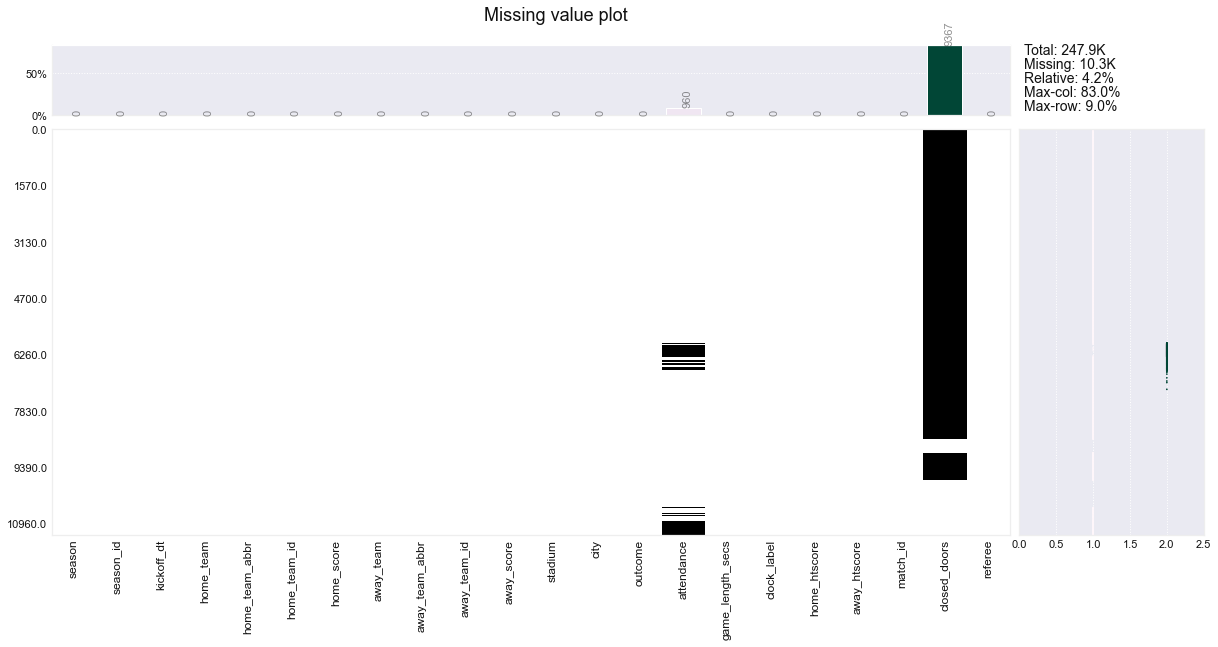

In [85]:
klib.missingval_plot(df_games, figsize=(20, 9));

This visual describes the missing values in the dataset. See it as a copy of the entire dataset where missing values are replaced by thin black lines and non-missing values by white.

Here we can see that most of the missing values come from the `attendance` and `closed_doors`. 
After some research, it seems like the `attendance` for the games around the 6000th row were not recorded. the lasts one are mostly due to Covid-19 and closed stadiums.
For the closed doors this 

In [86]:
# missing_vals = df_games[df_games["closed_doors"].isna()]["attendance"].isna().sum()
# print(f"Where closed_doors is null, attendance is null {missing_vals} times.")

df_games[~df_games["closed_doors"].isna()]

,season,season_id,kickoff_dt,home_team,home_team_abbr,home_team_id,home_score,away_team,away_team_abbr,away_team_id,away_score,stadium,city,outcome,attendance,game_length_secs,clock_label,home_htscore,away_htscore,match_id,closed_doors,referee
8606,2014/15,27,2014-12-07 16:00:00,aston villa,avl,2,2,leicester city,lei,26,1,villa park,birmingham,h,27692.0,5700,90 +5'00,1,1,9758,False,craig pawson
8607,2014/15,27,2014-12-26 15:00:00,sunderland,sun,29,1,hull city,hul,41,3,stadium of light,sunderland,a,44817.0,5880,90 +8'00,1,1,9788,False,andre marriner
8608,2014/15,27,2015-03-22 16:00:00,queens park rangers,qpr,17,1,everton,eve,7,2,loftus road,london,a,17706.0,5760,90 +6'00,0,1,9909,False,jonathan moss
8609,2014/15,27,2014-11-08 15:00:00,west ham united,whu,25,0,aston villa,avl,2,0,boleyn ground,london,d,34857.0,5760,90 +6'00,0,0,9716,False,jonathan moss
8610,2014/15,27,2014-11-01 15:00:00,leicester city,lei,26,0,west bromwich albion,wba,36,1,king power stadium,leicester,a,31819.0,5760,90 +6'00,0,0,9705,False,stuart attwell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11262,2020/21,363,2020-12-15 18:00:00,wolverhampton wanderers,wol,38,2,chelsea,che,4,1,molineux stadium,wolverhampton,h,NaN,5940,90 +9'00,0,0,59023,True,stuart attwell
11263,2020/21,363,2020-09-13 16:30:00,tottenham hotspur,tot,21,0,everton,eve,7,1,tottenham hotspur stadium,london,a,NaN,5700,90 +5'00,0,0,58901,True,martin atkinson
11264,2020/21,363,2020-12-19 17:30:00,everton,eve,7,2,arsenal,ars,1,1,goodison park,liverpool,h,2000.0,5820,90 +7'00,2,1,59030,False,andre marriner
11265,2020/21,363,2020-10-04 14:00:00,wolverhampton wanderers,wol,38,1,fulham,ful,34,0,molineux stadium,wolverhampton,h,NaN,5700,90 +5'00,0,0,58935,True,darren england


**Replacing missing values**

In [87]:
df_games["closed_doors"] = df_games["attendance"].apply(lambda x: 0 if x > 0 else 1)

In [88]:
missing(df_games)

,missing_val_count,missing_val_percent
attendance,960,8.5


### Fe

Adding ref count, the total number of time the referee was refereeing.

In [89]:
ref_val_count = df_games["referee"].value_counts().to_dict()
df_games["ref_count"] = df_games["referee"].apply(lambda x: ref_val_count[x])

## Events

In [90]:
df_events.head()

,clock_secs,clock_label,phase,type,time_millis,time_label,time_gmtOffset,score_homeScore,score_awayScore,id,personId,teamId,description,assistId,match_id
0,0,00'00,1,PS,1.120483e+12,"4 July 2005, 14:08",1.0,0,0,NaN,NaN,NaN,NaN,NaN,147
1,2700,45'00,1,PE,1.120483e+12,"4 July 2005, 14:08",1.0,0,0,NaN,NaN,NaN,NaN,NaN,147
2,2700,45'00,2,PS,1.120483e+12,"4 July 2005, 14:08",1.0,0,0,NaN,NaN,NaN,NaN,NaN,147
3,4020,67'00,2,S,1.120484e+12,"4 July 2005, 14:30",1.0,0,0,552.0,322.0,12.0,ON,NaN,147
4,4020,67'00,2,S,1.120484e+12,"4 July 2005, 14:30",1.0,0,0,552.0,324.0,12.0,OFF,NaN,147


### Columns renaming

In [91]:
# Creating a list of unnecessary variables
unuseful_features = ["time_gmtOffset", "id", "time_millis", "time_label", "clock_secs"]


# Removing thoses variables
for col in df_events.columns:
    if col in unuseful_features:
        try:
            df_events.drop(col, axis=1, inplace=True)
        except:
            ...

            
# Creating a list of new names
replace = {
    "score_homeScore": "home_team_score",
    "score_awayScore": "away_team_score",
    "personId": "player_id",
    "teamId": "team_id", 
    "assistId": "assist_id",
    "Match ID": "match_id"}


# Renaming columns
df_events.rename(columns=replace, inplace=True)

df_events.head()

,clock_label,phase,type,home_team_score,away_team_score,player_id,team_id,description,assist_id,match_id
0,00'00,1,PS,0,0,NaN,NaN,NaN,NaN,147
1,45'00,1,PE,0,0,NaN,NaN,NaN,NaN,147
2,45'00,2,PS,0,0,NaN,NaN,NaN,NaN,147
3,67'00,2,S,0,0,322.0,12.0,ON,NaN,147
4,67'00,2,S,0,0,324.0,12.0,OFF,NaN,147


### Describe

In [92]:
df_events.describe(include="all").round(2)

,clock_label,phase,type,home_team_score,away_team_score,player_id,team_id,description,assist_id,match_id
count,205580,205580.00,205580,205580.00,205580.00,169374.00,169420.00,169417,20338.00,205580.00
unique,117,NaN,9,NaN,NaN,NaN,NaN,10,NaN,NaN
top,45'00,NaN,S,NaN,NaN,NaN,NaN,ON,NaN,NaN
freq,21377,NaN,103294,NaN,NaN,NaN,NaN,51647,NaN,NaN
mean,NaN,1.78,NaN,1.06,0.79,3723.22,20.65,NaN,3182.08,11261.12
std,NaN,0.42,NaN,1.12,0.96,5476.11,20.72,NaN,4527.45,14506.49
min,NaN,1.00,NaN,0.00,0.00,1.00,1.00,NaN,1.00,1.00
25%,NaN,2.00,NaN,0.00,0.00,1193.00,7.00,NaN,844.00,3260.00
50%,NaN,2.00,NaN,1.00,1.00,2437.00,19.00,NaN,2063.00,5939.00
75%,NaN,2.00,NaN,2.00,1.00,4135.00,28.00,NaN,3929.00,9857.00


### Infos

In [93]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205580 entries, 0 to 205579
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   clock_label      205580 non-null  object 
 1   phase            205580 non-null  int64  
 2   type             205580 non-null  object 
 3   home_team_score  205580 non-null  int64  
 4   away_team_score  205580 non-null  int64  
 5   player_id        169374 non-null  float64
 6   team_id          169420 non-null  float64
 7   description      169417 non-null  object 
 8   assist_id        20338 non-null   float64
 9   match_id         205580 non-null  int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 15.7+ MB


### Missing values

In [94]:
missing(df_events)

,missing_val_count,missing_val_percent
player_id,36206,17.6
team_id,36160,17.6
description,36163,17.6
assist_id,185242,90.1


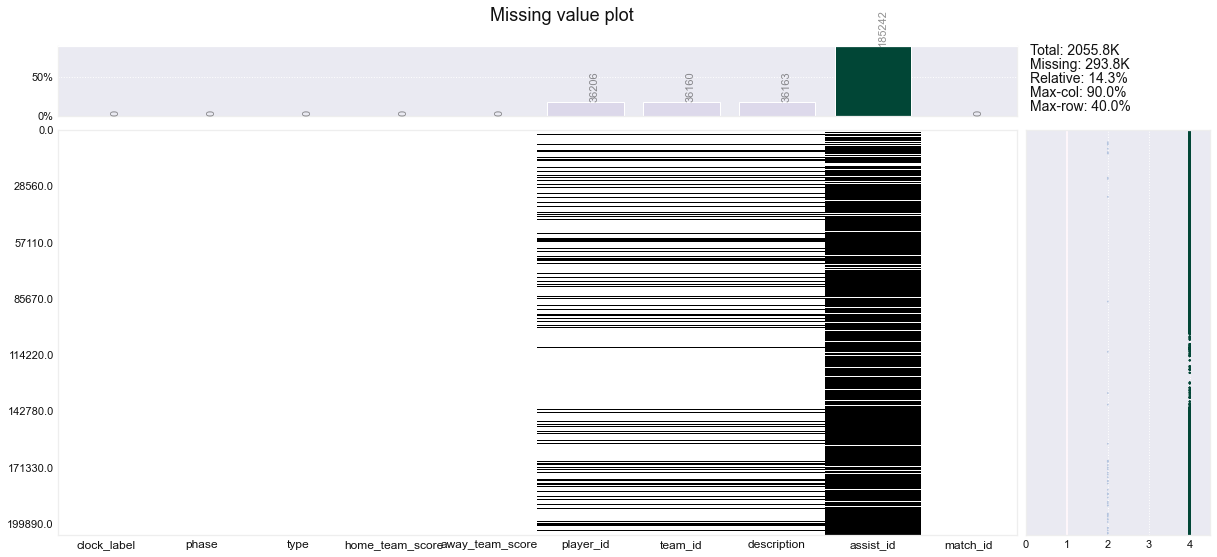

In [95]:
klib.missingval_plot(df_events, figsize=(20, 9));

There features have almost the exact same number of  missing values and it looks like they are at the same indexes. What are those events? 

In [96]:
# Lowering all 
for col in df_events.columns:
    df_events[col] = df_events[col].apply(lambda x: x.lower() if type(x)==str else x)

# Replacing abbreviation for better understanding
typee = {"s": "substitution",
         "b": "card",
         "g": "goal",
         "pe": "play_end",
         "ps": "play_start",
         "p": "goal", 
         "o": "own_goal",
         "sp": "penalty_saved",
         "mp": "penalty_missed"} 

description = {
    "y": "yellow_card",
    "r": "red_card",
    "yr": "2y_red_card",
    "g": "goal",
    "o": "own_goal",
    "p": "penalty", 
    "on": "sub_on", 
    "off": "sub_off",
    "sp": "penalty_saved",
    "mp": "penalty_missed"}


df_events["description"].replace(description, inplace=True)
df_events["type"].replace(typee, inplace=True)

In [97]:
df_events[df_events["player_id"].isna()]["type"].value_counts()

play_start      18080
play_end        18080
substitution       40
card                6
Name: type, dtype: int64

**Play start & play end** 

There are missing values for the events `play_start` et `play_end` which is normal as it doesn't involve any player, any team and there are no corresponding description for it.

**Subsitution**

It's definitely that but there are still 40 `s` missing.

In [98]:
missing_sub = df_events[(df_events["player_id"].isna()) & (df_events["type"]=="substitution")]
indexes = missing_sub[missing_sub["description"]=="sub_on"].index

The 40 `substitution` missing are mostly players that never came in. When a player is substituted, a player is supposed to come on the pitch but here, nobody came in as the [game's page](https://www.premierleague.com/match/8224) of most games shows when you hover your mouse over `90+` on the time line. The reason why there are missing values is that I guess, as everything is automated, when a player goes out, a new data entry is automatically generated for the player in but as nobody came in there are missing values. We can drop them, they are irrelevant.
For the three others where it's written `sub_off`, the id of the player who came on the pitch has not been recorded so 'ill add it manually by finding the player name on [match en direct](matchendirect.fr) (French website with live football).

In [99]:
# Dropping sub_on rows
df_events.drop(indexes, inplace=True)


# Adding player_id
df_events.loc[6261, "player_id"] = 305
df_events.loc[168355, "player_id"] = 21731
df_events.loc[169988, "player_id"] = 21731

**Card**

In [100]:
indexes = df_events[(df_events["player_id"].isna()) & (df_events["type"]=="card")].index

After some research, I found out that they are just forgotten players. Thanks again to [match en direct](https://www.matchendirect.fr/f), I found out that those events are not correct and nothing happened at this time in the game. No card was given. 

In [101]:
df_events.drop(indexes, axis=0, inplace=True)

**Description**

In [102]:
indexes = df_events[(df_events["description"].isna()) & (df_events["type"]=="card")].index
df_events[(df_events["description"].isna()) & (df_events["type"]=="card")]

,clock_label,phase,type,home_team_score,away_team_score,player_id,team_id,description,assist_id,match_id
6856,45'00,2,card,1,1,798.0,25.0,NaN,NaN,923
24255,45'00,2,card,0,0,712.0,20.0,NaN,NaN,1581
33952,45'00,2,card,0,1,1461.0,20.0,NaN,NaN,2221


After doing some research, I found out, again that those where errors and nothing happened at those times.

In [103]:
df_events.drop(indexes, axis=0, inplace=True)

**Missing values**

In [104]:
missing(df_events)

,missing_val_count,missing_val_percent
player_id,36160,17.6
team_id,36160,17.6
description,36160,17.6
assist_id,185196,90.1


Alright, the others missing values for the top three rows come from the play_end and play_start so it's normal and `assist_id` comes from the fact that it needs a goal to be filled by player id (the one who did the last pass to the scorer). Among the `36160` missing values, half of it for the start of the first half of the game and the second half for the start of the second one. However, for each game, there are two starts and two ends. the thing is that 36k/4 is not equal to the total number of games in df_games so there are some games which don't have play_start and play_end. 

**play_start, play_end**

After digging down into the dataset I found out that some games, around 2,000 didn't have either play start or play end. This might b e a ploblem later if I decide to calculate something on it.

In [105]:
# Formatting time to have it as integer
df_events["add_time"] = df_events["clock_label"].apply(lambda x: int(x.split("+")[1].split("'")[0]) if "+" in x else 0)
df_events["clock_label"] = df_events["clock_label"].apply(lambda x: int(x[:2]))

# collecting missing values
missing_ids = set(df_games["match_id"].unique()) - set(df_events[df_events["type"]=="play_end"]["match_id"].unique())
missing_ids = list(missing_ids)

to_add = []
for missing_id in tqdm(missing_ids):

    sub = df_events[df_events["match_id"]==missing_id]

    # If there is an error, then there was no event meaning score: 0-0
    try:
        ht_score = sub[sub["clock_label"]<46].iloc[-1, 3:5]
    except IndexError: ht_score = [0, 0] 
        
    ft_score = sub.iloc[-1, 3:5]

    to_add.extend([[0, 1, "play_start", 0, 0] + [np.nan]*4 + [missing_id, 0], 
                   [45, 1, "play_end", ht_score[0], ht_score[1]] + [np.nan]*4 + [missing_id, 0], 
                   [45, 2, "play_start", ht_score[0], ht_score[1]] + [np.nan]*4 + [missing_id, 0], 
                   [90, 2, "play_end", ft_score[0], ft_score[1]] + [np.nan]*4 + [missing_id, 0]])


to_add = pd.DataFrame(to_add, columns=df_events.columns)
df_events = pd.concat([df_events, to_add], axis = 0)

100%|█████████████████████████████████████| 2227/2227 [00:01<00:00, 1996.28it/s]


In [106]:
df_events[df_events["player_id"].isna()]["type"].value_counts()

play_start    22534
play_end      22534
Name: type, dtype: int64

Awesome! There are now `22534` missing values for play_start and end which corresponds to twice the number of games ever in PL.

### Adding outcome 

In [107]:
# df_events["outcome"] = df_events[["home_team_score", "away_team_score"]]\
#     .apply(lambda x: ("h" if x["home_team_score"] > x["away_team_score"] else "a") \
#            if x["home_team_score"] != x["away_team_score"] else "d",
#            axis=1)

## Players

In [108]:
df_players.head(5)

,matchPosition,matchShirtNumber,captain,playerId,info_position,info_positionInfo,nationalTeam_isoCode,nationalTeam_country,nationalTeam_demonym,birth_date_millis,birth_date_label,birth_country_isoCode,birth_country_country,birth_country_demonym,age,name_display,name_first,name_last,id,altIds_opta,substitute,team_id,info_shirtNum,birth_place,match_id,name_middle,info_loan,nationalTeam
0,M,99.0,False,0,M,Midfielder,RU,Russia,Russian,-2.963520e+10,23 January 1969,RU,Russia,Russian,23 years 282 days,Andrei Kanchelskis,Andrei,Kanchelskis,324,p2329,0,12,NaN,NaN,147,NaN,NaN,NaN
1,D,99.0,False,0,D,Defender,GB-ENG,England,English,-1.422144e+11,30 June 1965,GB-ENG,England,English,27 years 123 days,Gary Pallister,Gary,Pallister,320,p1844,0,12,NaN,NaN,147,NaN,NaN,NaN
2,D,99.0,False,0,D,Defender,GB-ENG,England,English,-2.840832e+11,31 December 1960,GB-ENG,England,English,31 years 305 days,Steve Bruce,Steve,Bruce,319,p10775,0,12,NaN,NaN,147,NaN,NaN,NaN
3,F,99.0,False,0,F,Forward,GB-WLS,Wales,Welsh,-1.946592e+11,1 November 1963,GB-WLS,Wales,Welsh,28 years 365 days,Mark Hughes,Mark,Hughes,339,p1925,0,12,NaN,NaN,147,NaN,NaN,NaN
4,D,99.0,False,0,D,Defender,GB-ENG,England,English,-1.812672e+11,4 April 1964,GB-ENG,England,English,28 years 210 days,Paul Parker,Paul,Parker,317,p12751,0,12,NaN,NaN,147,NaN,NaN,NaN


### Columns renaming

In [109]:
for col in df_players.columns:
    df_players[col] = df_players[col].apply(lambda x: x.lower() if type(x)==str else x)

# Creating a list of unnecessary variables
unuseful_features = ["nationalTeam_demonym", "birth_date_millis", "playerId", 
                    "birth_country_demonym", "name_first", "name_last", "altIds_opta", "name_middle", 
                    "nationalTeam", "nationalTeam_isoCode", 
                     "birth_place", "name_middle", "info_shirtNum"]


# Removing thoses variables
for col in unuseful_features:
    try:
        df_players.drop(col, axis=1, inplace=True)
    except:
        ...

            
# Creating a list of new names       
replace = {"score_homeScore": "home_team_score", 
          "matchPosition": "match_position", 
          "playerId": "player_id", 
          "nationalTeam_country": "nateam", 
          "birth_country_country": "birth_country", 
          "birth_date_label": "birth_date", 
          "name_display": "player_name", 
          "id": "player_id", 
           "info_position": "normal_position",
          "info_positionInfo": "full_position", 
          "Match ID": "match_id", 
          "matchShirtNumber": "player_number"}


# Renaming columns
df_players.rename(columns=replace, inplace=True)

nb_players = len(set(df_players["player_id"]))
print(f"Shape: {df_players.shape[0]:,}/{df_players.shape[1]} | Unique players: {nb_players:,}")
df_players.head(1)

Shape: 346,951/16 | Unique players: 4,863


,match_position,player_number,captain,normal_position,full_position,nateam,birth_date,birth_country_isoCode,birth_country,age,player_name,player_id,substitute,team_id,match_id,info_loan
0,m,99.0,False,m,midfielder,russia,23 january 1969,ru,russia,23 years 282 days,andrei kanchelskis,324,0,12,147,NaN


### Table splitting 

As df_players is redundant, I'm going to divide it into two dataframes: 
* df_players_infos: containing all individual players informations 
* df_lineup: containing all players lined up for all games 

In [110]:
df_players.head(5)

,match_position,player_number,captain,normal_position,full_position,nateam,birth_date,birth_country_isoCode,birth_country,age,player_name,player_id,substitute,team_id,match_id,info_loan
0,m,99.0,False,m,midfielder,russia,23 january 1969,ru,russia,23 years 282 days,andrei kanchelskis,324,0,12,147,NaN
1,d,99.0,False,d,defender,england,30 june 1965,gb-eng,england,27 years 123 days,gary pallister,320,0,12,147,NaN
2,d,99.0,False,d,defender,england,31 december 1960,gb-eng,england,31 years 305 days,steve bruce,319,0,12,147,NaN
3,f,99.0,False,f,forward,wales,1 november 1963,gb-wls,wales,28 years 365 days,mark hughes,339,0,12,147,NaN
4,d,99.0,False,d,defender,england,4 april 1964,gb-eng,england,28 years 210 days,paul parker,317,0,12,147,NaN


Before Splitting the values, I need to change some values of normal position. This column is supposed to be the normal position of the player and not the one he played at during the game. Some players have multiple normal position as it changed during their career as they got better at another position. For that, I will make sure that every player has only one normal position, the most frequent one.

In [111]:
# replacing all normal position of the most frequent value for each player
for pid in tqdm(df_players["player_id"].unique()):
    sub = df_players[df_players["player_id"]==pid]
    indexes = sub.index
    df_players.loc[indexes, "normal_position"] = sub["normal_position"].mode().squeeze()


100%|██████████████████████████████████████| 4863/4863 [00:17<00:00, 270.18it/s]


In [112]:
# Defining columns for which values will be the same for all games 
infos_cols = ["nateam", "birth_date", "birth_country_isoCode", "birth_country", 
              "player_name", "player_id", "normal_position"]

df_players_info = df_players[infos_cols].drop_duplicates().reset_index(drop=True)


lineup_cols = list(set(df_players.columns) - set(infos_cols)) + ["player_name", "player_id"]
df_lineup = df_players[lineup_cols].reset_index(drop=True)

## Players info

In [113]:
missing(df_players_info)

,missing_val_count,missing_val_percent
nateam,62,1.3
birth_date,2,0.0
birth_country,60,1.2
normal_position,2,0.0


**Birth date**

In [114]:
df_players_info.loc[df_players_info.birth_date.isna()]

,nateam,birth_date,birth_country_isoCode,birth_country,player_name,player_id,normal_position
4788,england,NaN,gb-eng,england,taylor gardner-hickman,26714,f
4789,england,NaN,gb-eng,england,caleb taylor,53789,d


In [115]:
df_players_info.loc[4788, "birth_date"] = "30 December 2001"
df_players_info.loc[4789, "birth_date"] = "14 January 2003"

In [116]:
df_players_info["birth_date"] = pd.to_datetime(df_players_info["birth_date"], format='%d %B %Y')

**Normal position**

In [117]:
df_players_info.loc[df_players_info.normal_position.isna()]

,nateam,birth_date,birth_country_isoCode,birth_country,player_name,player_id,normal_position
800,ghana,1974-12-10,gh,ghana,nii lamptey,846,NaN
1851,nigeria,1980-07-21,ng,nigeria,ifeanyi udeze,2367,NaN


In [118]:
df_players_info.loc[800, "normal_position"] = "F"
df_players_info.loc[1851, "normal_position"] = "D"

**Birth country**

If a player has missing val for birth country but not for nateam then we can consider that his birth_country is his national team. A player that plays for a national team might be born in this country but it's not sure as the FIFA has a rule saying a player can play for any team he has origin of (nationality of parents or grandparents). I will assume the players are born in the country for which they play for.

In [119]:
missing(df_players_info)

,missing_val_count,missing_val_percent
nateam,62,1.3
birth_country,60,1.2


In [120]:
for index, value in enumerate(df_players_info["birth_country"]):
    if pd.isnull(value) and pd.notnull(df_players_info.loc[index, "nateam"]):
        df_players_info.loc[index, "birth_country"] = df_players_info.loc[index, "nateam"]

In [121]:
missing(df_players_info)

,missing_val_count,missing_val_percent
nateam,62,1.3
birth_country,43,0.9


## Line-up

In [122]:
missing(df_lineup.drop(["info_loan", "match_position"], axis=1))

,missing_val_count,missing_val_percent
full_position,82,0.0
player_number,672,0.2
age,6,0.0


**Match position**

In [123]:
 df_lineup[(df_lineup["match_position"].isna()) & (df_lineup["substitute"]==0)]

,info_loan,substitute,match_id,team_id,captain,full_position,player_number,age,match_position,player_name,player_id


As we can see, when subsetting the `match_position` column where there are missing values and where substitute is `0` there are no values so missing values on `match_position` means that the player started the game as substitute. 

In [124]:
# Replacing misssing values by substitute as S
df_lineup["match_position"].fillna("S", inplace=True)

**Player number**

In [125]:
df_lineup["player_number"].value_counts().head()

99.0    93779
1.0     11073
10.0    10691
5.0     10081
8.0      9899
Name: player_number, dtype: int64

Most of the players number are 99 which is an error as the 99th number is rarely given. In a quarter-final tie on 17 December 2019, Liverpool player Tom Hill became the first player in English football history to wear the number 99 shirt in a competitive match. After checking the data and the PL website, 99 correspond to missing values.

In [126]:
df_lineup["player_number"] = df_lineup["player_number"].apply(lambda x: np.nan if x == 99 else x)

In [127]:
df_lineup[df_lineup["player_number"].isna()]\
.merge(df_games[["season", "match_id"]], how="left")\
["season"].value_counts()

1992/93    11248
1994/95    10980
1993/94    10860
1997/98     9044
1995/96     8921
1996/97     8907
1998/99     8805
1999/00     8055
2000/01     7360
2001/02     5826
2002/03     4469
2003/04       18
2006/07        3
2004/05        1
Name: season, dtype: int64

**Full position**

Replacing missing values with the mode of the normal position subset.

In [128]:
for position in tqdm(df_lineup["match_position"].unique()):
    sub = df_lineup[(df_lineup["full_position"].isna()) & (df_lineup["match_position"]==position)]
    indexes = sub.index
    df_lineup.loc[indexes, "full_position"] = df_lineup[df_lineup["match_position"]==position]["full_position"].mode().squeeze()        

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 22.10it/s]


**Replacing missing values age**
Replacing the whole columns is actually easier and faster

In [129]:
sub = df_lineup.merge(df_games[["kickoff_dt", "match_id"]], how="left")\
         .merge(df_players_info[["player_id", "birth_date"]], how="left")


df_lineup["age"] = (sub["kickoff_dt"] - sub["birth_date"]) / np.timedelta64(1, 'Y')

### Infos

In [130]:
df_players["birth_date"] = pd.to_datetime(df_players["birth_date"], format='%d %B %Y')

df_players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346951 entries, 0 to 346950
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   match_position         328820 non-null  object        
 1   player_number          346279 non-null  float64       
 2   captain                346951 non-null  bool          
 3   normal_position        346928 non-null  object        
 4   full_position          346869 non-null  object        
 5   nateam                 342217 non-null  object        
 6   birth_date             346945 non-null  datetime64[ns]
 7   birth_country_isoCode  346951 non-null  object        
 8   birth_country          341981 non-null  object        
 9   age                    346945 non-null  object        
 10  player_name            346951 non-null  object        
 11  player_id              346951 non-null  int64         
 12  substitute             346951 non-null  int6

### Missing values

In [131]:
missing(df_players)

,missing_val_count,missing_val_percent
match_position,18131,5.2
player_number,672,0.2
normal_position,23,0.0
full_position,82,0.0
nateam,4734,1.4
birth_date,6,0.0
birth_country,4970,1.4
age,6,0.0
info_loan,336465,97.0


Here it seems that some columns are correlated for the missing values: 
* Both positions columns 
* Age and birth date 

Info loan has many missing values which is normal as most players are bought from club to clubs and not loaned.

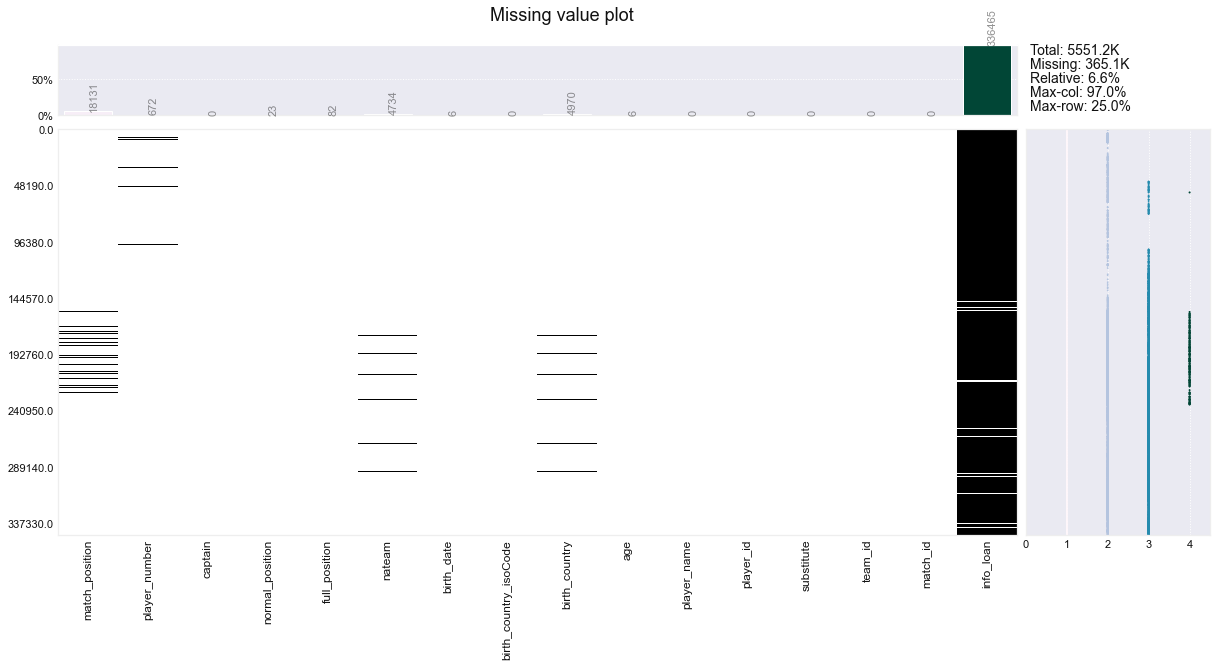

In [132]:
klib.missingval_plot(df_players, figsize=(20, 9));



**Normal position & full position**


In [133]:
names = df_players[df_players["normal_position"].isna()]["player_name"].value_counts().index.to_list()



for name in names: 
    indexes = list(df_players[(df_players["normal_position"].isna()) &  
                                  (df_players["player_name"]==name)].index)
    # Some players have full missing values on all rows so they throw an error 
    try:
        normal_position, full_position = tuple(df_players[(df_players["player_name"]==name) & \
                                                          (df_players["normal_position"].notna())]\
                                                          .reset_index(drop=True)\
                                                          .loc[0, ["normal_position", "full_position"]])

        df_players.loc[indexes, "normal_position"] = normal_position
        df_players.loc[indexes, "full_position"] = full_position
        
        
    except: 
        match_position = df_players[df_players["player_name"]==name]["match_position"].mode()[0]
        df_players.loc[indexes, "normal_position"] = match_position

        full_position = df_players[df_players["normal_position"]==match_position]["full_position"]\
                                                                                 .mode()[0]
        df_players.loc[indexes, "full_position"] = full_position

I managed to fill some missing values but there are still some players for whom I don't know any of the position they ever played at. I still have the position they played during the game they played so I'm going to assume it's their normal position and then take the mode of the full position based on a subset of their position.

In [134]:
missing(df_players)

,missing_val_count,missing_val_percent
match_position,18131,5.2
player_number,672,0.2
full_position,71,0.0
nateam,4734,1.4
birth_date,6,0.0
birth_country,4970,1.4
age,6,0.0
info_loan,336465,97.0


In [135]:
df_players.shape

(346951, 16)

**Infos_loan:** Players on loan from another club are rare, nothing surprising

**Birth_country:** I assume this wasn't recorded but we can assume it's the nateam if the player has one. In football a player can play for any team has origin in. The origin being his, parents or grandpareants. I will assume that if the birth_country of a player is missing, the nateam is his birth_country

**Nateam:** Maybe the player didn't have one as he was not good enough to be selected. 


In [136]:
no_birth_country = list(df_players[df_players["birth_country"].isna()]["player_name"].unique())
no_nateam = list(df_players[df_players["nateam"].isna()]["player_name"].unique())

len(set(no_birth_country + no_nateam)), len(no_birth_country), len(no_nateam)

(79, 60, 62)

In [137]:
df_players["birth_country"].isna().sum()

4970

In [138]:
birth_country = []
for index, cb in enumerate(df_players["birth_country"]):
    if pd.isnull(cb):
        birth_country.append(df_players.loc[index, "nateam"])
        
    else: 
        birth_country.append(cb)
        
df_players["birth_country"] = birth_country

In [139]:
df_players["birth_country"].isna().sum()

3680

Even though `birth_country` has more missing values than `nateam`, there are more players that don't have national team. 

Awesome, the data is finally clean! 

In [140]:
df_players.isna().sum()

match_position            18131
player_number               672
captain                       0
normal_position               0
full_position                71
nateam                     4734
birth_date                    6
birth_country_isoCode         0
birth_country              3680
age                           6
player_name                   0
player_id                     0
substitute                    0
team_id                       0
match_id                      0
info_loan                336465
dtype: int64

### Wrong values 


In [141]:
# # this is too check players who have multiple positions
# count = 0
# players = []
# for x in tqdm(df_players["player_name"].unique()):
#     subset = df_players[df_players["player_name"]==x]
    
#     if len(subset["normal_position"].unique()) > 1:
#         players.append(x)
#         count += 1

# print(f"{count} player have multiple position")

As said earlier, (did I? check that later) normal position is the position that a player normally plays at and te match position is the one he played during the gale. Some player have a different position overtime which might be due to the evolution of the player and that e found a position where he is better at after some time in his career. For that I will change his normal position to the position he played the most (mode of normal position).

In [142]:
for name in tqdm(df_players["player_name"].unique()):
    sub = df_players[df_players["player_name"]==name]
    indexes = sub.index
    df_players.loc[indexes, "normal_position"] = sub["normal_position"].mode().squeeze()
#     position = df_players.loc[df_players["player_name"]==name, "normal_position"].value_counts().index[0]
#     df_players.loc[df_players["player_name"]==name, "normal_position"] = position

100%|███████████████████████████████████████| 4826/4826 [01:03<00:00, 76.30it/s]


In [143]:
df_players[df_players["player_name"]=="raheem sterling"]["normal_position"].value_counts()

f    319
Name: normal_position, dtype: int64

### Fe

In [144]:
players_val_count = df_players["player_name"].value_counts().to_dict()
df_players["player_count"] = df_players["player_name"].apply(lambda x: players_val_count[x])

In [145]:
df_players = df_lineup.merge(df_players_info)

## Stats



In [146]:
# Creating new df to store the stats
sub_df = pd.DataFrame()

for index, element in enumerate(tqdm(df_stats["stats"])):
    element = element.split("\n") 
    for stats in element:
        if any(char.isdigit() for char in stats):
            stats = stats.lower()
            stat_home = stats.split(" ")[0] # When slit, first element of the list is the home stat
            stat_away = stats.split(" ")[-1] # When slit, last element of the list is the away stat
            stat = stats.replace(stat_home+" ", "").replace(" "+stat_away, "").replace(" ", "_")

            # this is bad code (long) change that later
            sub_df.loc[df_stats.loc[index, "match_id"], [stat+"_home", stat+"_away"]] = [stat_home, stat_away]
    sub_df.loc[index, "match_id"] = df_stats.loc[index, "match_id"]
    
# If no red card was given, the stat was not displayed on the page. When added to df --> NAN
df_stats = sub_df.fillna(0)

df_stats.head(1)

100%|██████████████████████████████████████| 5631/5631 [00:37<00:00, 148.29it/s]


,possession_%_home,possession_%_away,shots_on_target_home,shots_on_target_away,shots_home,shots_away,touches_home,touches_away,passes_home,passes_away,tackles_home,tackles_away,clearances_home,clearances_away,corners_home,corners_away,offsides_home,offsides_away,yellow_cards_home,yellow_cards_away,fouls_conceded_home,fouls_conceded_away,match_id,red_cards_home,red_cards_away
5597,53.2,46.8,8,2,23,7,643,523,433,377,27,25,41,24,6,3,3,1,2,1,12,9,59196.0,0,0


In [147]:
# Ronaldo was a forward not midfielder 
indexes = df_players[df_players.player_name.str.contains("ronaldo")].index
df_players.loc[indexes, "normal_position"] = "f"

# Droppping duplicate value
df_games.drop(11251, inplace=True)

In [159]:
df_players[(df_players.normal_position=="g") & (df_players.substitute==0) & (df_players.match_id==147)]

df_players.drop([1279, 3170], inplace=True)

In [160]:
df_players[(df_players.normal_position=="g") & (df_players.substitute==0) & (df_players.match_id==147)]

,info_loan,substitute,match_id,team_id,captain,full_position,player_number,age,match_position,player_name,player_id,nateam,birth_date,birth_country_isoCode,birth_country,normal_position
969,NaN,0,147,12,False,goalkeeper,NaN,29.001622,g,peter schmeichel,307,denmark,1963-11-18,dk,denmark,g
3289,NaN,0,147,22,False,goalkeeper,NaN,27.121250,g,hans segers,582,netherlands,1961-10-30,nl,netherlands,g


# Export the dfs

In [161]:
df_games.to_csv("data/clean_games.csv", index=False)
df_events.to_csv("data/clean_events.csv", index=False)
df_players.to_csv("data/clean_players.csv", index=False)
df_players_info.to_csv("data/clean_players_info.csv", index=False)
df_lineup.to_csv("data/clean_lineup.csv", index=False)
df_stats.to_csv("data/clean_stats.csv", index=False)